In [1]:
import sys
import os
import yaml
import random
import numpy as np

sys.path.insert(0, '../')

import utils.utils as utils

from pathlib import Path

from utils.data_utils import get_gen
from utils.plotting import plot_tsne_by_cluster, plot_group_kaplan_meier, plot_tsne_by_survival
from utils.eval_utils import cindex, calibration, accuracy_metric, cindex_metric
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score

from datasets.survivalMNIST.survivalMNIST_data import generate_surv_MNIST

# TensorFlow imports
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfkl = tf.keras.layers
tfpl = tfp.layers
tfk = tf.keras

# VaDeSC model
from models.losses import Losses
from models.model import GMM_Survival

import matplotlib.pyplot as plt

%matplotlib inline

/local/home/anaconda3/envs/Survival_Cluster_Analysis/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [2]:
def setup_seed(seed):
    random.seed(seed)  
    np.random.seed(seed) 
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  

In [3]:
# Fix random seed
seed = 20220229
setup_seed(seed)

### survMNIST Data

In [4]:
# Generate survival MNIST data
x_train, x_test, t_train, t_test, d_train, d_test, c_train, c_test =\
    generate_surv_MNIST(n_groups=5, seed=seed, p_cens=0.3, valid_perc=0)

# Normalise images
x_train = x_train / 255.
x_test = x_test / 255.

# Wrap t, d, and c together
y_train = np.stack([t_train, d_train, c_train], axis=1)
y_test = np.stack([t_test, d_test, c_test], axis=1)

--------------------------------------------------
Cluster Assignments & Risk Scores:
Digit:       [0 1 2 3 4 5 6 7 8 9]
Risk group:  [0 0 3 2 0 4 3 1 1 1]
Risk score:  [ 3.31123304  3.31123304  1.86252627 10.29560333  3.31123304  6.21324987
  1.86252627  8.75617551  8.75617551  8.75617551]
--------------------------------------------------




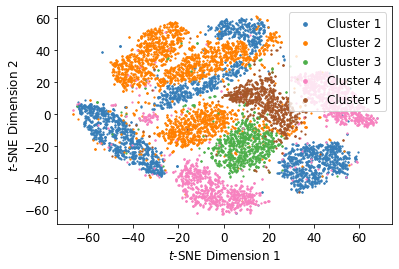

In [5]:
# Visualise t-SNE of images colour data points according to the cluster
plot_tsne_by_cluster(X=x_train, c=c_train, font_size=12, seed=42)

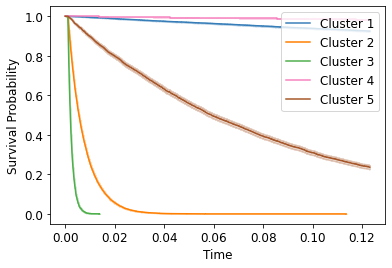

In [6]:
# Plot cluster-specific Kaplan-Meier curves
plot_group_kaplan_meier(t=t_train, d=d_train, c=c_train)

### VaDeSC Model

In [7]:
# Load config file for the MNIST
project_dir = os.path.dirname(os.getcwd())
config_path = Path(os.path.join(project_dir, 'configs/mnist.yml'))
with config_path.open(mode='r') as yamlfile:
    configs = yaml.safe_load(yamlfile)
print(configs)

{'data': {'data_name': 'MNIST'}, 'training': {'eval_frequency': 200, 'inp_shape': 784, 'latent_dim': 16, 'activation': 'sigmoid', 'monte_carlo': 1, 'num_clusters': 5, 'learn_prior': True, 'weibull_shape': 1, 'survival': True, 'sample_surv': True}}


In [8]:
# Define reconstruction loss function
losses = Losses(configs)
rec_loss = losses.loss_reconstruction_binary

In [10]:
# Fix seeds
setup_seed(seed)

In [11]:
# Construct the model & optimizer
model = GMM_Survival(**configs['training'])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.00001)
model.compile(optimizer, loss={"output_1": rec_loss}, 
              metrics={"output_4": accuracy_metric, "output_5": cindex_metric})
# Use survival times during training
tf.keras.backend.set_value(model.use_t, np.array([1.0]))

In [12]:
# Data generators
gen_train = get_gen(x_train, y_train, configs, 256)
gen_test = get_gen(x_test, y_test, configs, 256, validation=True)

### Training & Evaluation

In [13]:
# Fit the model
model.fit(gen_train, validation_data=gen_test, epochs=300)

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
234/234 [==============================] - ETA: 0s - loss: 247.4733 - output_1_loss: 228.7563 - output_4_accuracy_metric: 0.0610 - output_5_cindex_metric: 0.6993 - loss_clustering: 24.0988 - loss_prior: 1.5995 - loss_variational_1: -5.3705 - loss_variational_2: -0.9673 - loss_survival: -0.6327WARNING:tensorflow:AutoGraph could not transform <function M

234/234 [==============================] - 2s 9ms/step - loss: 120.4534 - output_1_loss: 91.4897 - output_4_accuracy_metric: 0.5172 - output_5_cindex_metric: 0.8743 - loss_clustering: 23.9039 - loss_prior: 1.2831 - loss_variational_1: 5.6215 - loss_variational_2: -0.2780 - loss_survival: -1.5567 - val_loss: 112.3304 - val_output_1_loss: 87.0479 - val_output_4_accuracy_metric: 0.5475 - val_output_5_cindex_metric: 0.8437 - val_loss_clustering: 19.9320 - val_loss_prior: 1.2710 - val_loss_variational_1: 5.6505 - val_loss_variational_2: -0.2331 - val_loss_survival: -1.3378
Epoch 12/300
234/234 [==============================] - 2s 10ms/step - loss: 119.8177 - output_1_loss: 90.7479 - output_4_accuracy_metric: 0.5345 - output_5_cindex_metric: 0.8752 - loss_clustering: 23.9009 - loss_prior: 1.2806 - loss_variational_1: 5.7240 - loss_variational_2: -0.2524 - loss_survival: -1.5691 - val_loss: 111.5495 - val_output_1_loss: 86.3070 - val_output_4_accuracy_metric: 0.5638 - val_output_5_cindex_met

Epoch 25/300
234/234 [==============================] - 2s 10ms/step - loss: 112.9082 - output_1_loss: 82.4857 - output_4_accuracy_metric: 0.6705 - output_5_cindex_metric: 0.8823 - loss_clustering: 23.8992 - loss_prior: 1.2355 - loss_variational_1: 7.0731 - loss_variational_2: -0.0921 - loss_survival: -1.6449 - val_loss: 106.8452 - val_output_1_loss: 79.5705 - val_output_4_accuracy_metric: 0.6832 - val_output_5_cindex_metric: 0.8470 - val_loss_clustering: 20.1507 - val_loss_prior: 1.2365 - val_loss_variational_1: 7.3765 - val_loss_variational_2: -0.0845 - val_loss_survival: -1.4045
Epoch 26/300
234/234 [==============================] - 2s 10ms/step - loss: 112.6884 - output_1_loss: 82.1035 - output_4_accuracy_metric: 0.6693 - output_5_cindex_metric: 0.8814 - loss_clustering: 23.8940 - loss_prior: 1.2341 - loss_variational_1: 7.1744 - loss_variational_2: -0.0896 - loss_survival: -1.6461 - val_loss: 106.3907 - val_output_1_loss: 79.4895 - val_output_4_accuracy_metric: 0.6850 - val_outpu

Epoch 39/300
234/234 [==============================] - 2s 9ms/step - loss: 109.6196 - output_1_loss: 78.5003 - output_4_accuracy_metric: 0.6792 - output_5_cindex_metric: 0.8804 - loss_clustering: 23.6877 - loss_prior: 1.2506 - loss_variational_1: 7.9423 - loss_variational_2: -0.0761 - loss_survival: -1.6490 - val_loss: 104.2780 - val_output_1_loss: 76.8662 - val_output_4_accuracy_metric: 0.6904 - val_output_5_cindex_metric: 0.8456 - val_loss_clustering: 20.0605 - val_loss_prior: 1.2543 - val_loss_variational_1: 7.5775 - val_loss_variational_2: -0.0722 - val_loss_survival: -1.4082
Epoch 40/300
234/234 [==============================] - 2s 9ms/step - loss: 109.7553 - output_1_loss: 78.5243 - output_4_accuracy_metric: 0.6818 - output_5_cindex_metric: 0.8816 - loss_clustering: 23.6626 - loss_prior: 1.2555 - loss_variational_1: 8.0132 - loss_variational_2: -0.0762 - loss_survival: -1.6506 - val_loss: 104.5185 - val_output_1_loss: 76.6717 - val_output_4_accuracy_metric: 0.6852 - val_output_

Epoch 53/300
234/234 [==============================] - 2s 10ms/step - loss: 108.1244 - output_1_loss: 76.6763 - output_4_accuracy_metric: 0.7209 - output_5_cindex_metric: 0.8833 - loss_clustering: 23.2211 - loss_prior: 1.4003 - loss_variational_1: 8.6380 - loss_variational_2: -0.0916 - loss_survival: -1.6965 - val_loss: 104.1773 - val_output_1_loss: 75.7349 - val_output_4_accuracy_metric: 0.7365 - val_output_5_cindex_metric: 0.8477 - val_loss_clustering: 19.5923 - val_loss_prior: 1.4041 - val_loss_variational_1: 8.9835 - val_loss_variational_2: -0.0906 - val_loss_survival: -1.4468
Epoch 54/300
234/234 [==============================] - 2s 9ms/step - loss: 107.8630 - output_1_loss: 76.3760 - output_4_accuracy_metric: 0.7260 - output_5_cindex_metric: 0.8827 - loss_clustering: 23.1845 - loss_prior: 1.4038 - loss_variational_1: 8.6807 - loss_variational_2: -0.0890 - loss_survival: -1.6991 - val_loss: 103.6683 - val_output_1_loss: 75.8769 - val_output_4_accuracy_metric: 0.7332 - val_output

Epoch 67/300
234/234 [==============================] - 2s 9ms/step - loss: 107.0406 - output_1_loss: 75.3994 - output_4_accuracy_metric: 0.7678 - output_5_cindex_metric: 0.8885 - loss_clustering: 22.7989 - loss_prior: 1.4207 - loss_variational_1: 9.2093 - loss_variational_2: -0.0687 - loss_survival: -1.7216 - val_loss: 103.4754 - val_output_1_loss: 75.1539 - val_output_4_accuracy_metric: 0.7772 - val_output_5_cindex_metric: 0.8523 - val_loss_clustering: 19.2346 - val_loss_prior: 1.4224 - val_loss_variational_1: 9.2100 - val_loss_variational_2: -0.0687 - val_loss_survival: -1.4769
Epoch 68/300
234/234 [==============================] - 2s 9ms/step - loss: 106.8606 - output_1_loss: 75.1614 - output_4_accuracy_metric: 0.7702 - output_5_cindex_metric: 0.8874 - loss_clustering: 22.7783 - loss_prior: 1.4212 - loss_variational_1: 9.2572 - loss_variational_2: -0.0676 - loss_survival: -1.7233 - val_loss: 103.7564 - val_output_1_loss: 75.0371 - val_output_4_accuracy_metric: 0.7778 - val_output_

Epoch 81/300
234/234 [==============================] - 2s 9ms/step - loss: 106.0262 - output_1_loss: 74.1784 - output_4_accuracy_metric: 0.7823 - output_5_cindex_metric: 0.8895 - loss_clustering: 22.4300 - loss_prior: 1.4222 - loss_variational_1: 9.7467 - loss_variational_2: -0.0602 - loss_survival: -1.7280 - val_loss: 103.6293 - val_output_1_loss: 75.0546 - val_output_4_accuracy_metric: 0.7951 - val_output_5_cindex_metric: 0.8525 - val_loss_clustering: 18.8466 - val_loss_prior: 1.4196 - val_loss_variational_1: 9.8499 - val_loss_variational_2: -0.0589 - val_loss_survival: -1.4826
Epoch 82/300
234/234 [==============================] - 2s 9ms/step - loss: 106.0016 - output_1_loss: 74.1693 - output_4_accuracy_metric: 0.7811 - output_5_cindex_metric: 0.8880 - loss_clustering: 22.4152 - loss_prior: 1.4226 - loss_variational_1: 9.7625 - loss_variational_2: -0.0594 - loss_survival: -1.7277 - val_loss: 103.4731 - val_output_1_loss: 74.8616 - val_output_4_accuracy_metric: 0.7898 - val_output_

Epoch 95/300
234/234 [==============================] - 2s 10ms/step - loss: 105.3199 - output_1_loss: 73.4165 - output_4_accuracy_metric: 0.7919 - output_5_cindex_metric: 0.8889 - loss_clustering: 22.0898 - loss_prior: 1.4233 - loss_variational_1: 10.1936 - loss_variational_2: -0.0563 - loss_survival: -1.7290 - val_loss: 103.4591 - val_output_1_loss: 74.6552 - val_output_4_accuracy_metric: 0.7956 - val_output_5_cindex_metric: 0.8520 - val_loss_clustering: 18.5014 - val_loss_prior: 1.4240 - val_loss_variational_1: 10.4182 - val_loss_variational_2: -0.0564 - val_loss_survival: -1.4834
Epoch 96/300
234/234 [==============================] - 2s 10ms/step - loss: 105.4223 - output_1_loss: 73.5321 - output_4_accuracy_metric: 0.7888 - output_5_cindex_metric: 0.8881 - loss_clustering: 22.0704 - loss_prior: 1.4235 - loss_variational_1: 10.1850 - loss_variational_2: -0.0556 - loss_survival: -1.7293 - val_loss: 103.3944 - val_output_1_loss: 74.5337 - val_output_4_accuracy_metric: 0.7970 - val_ou

Epoch 109/300
234/234 [==============================] - 2s 10ms/step - loss: 105.0077 - output_1_loss: 73.0030 - output_4_accuracy_metric: 0.7923 - output_5_cindex_metric: 0.8906 - loss_clustering: 21.7593 - loss_prior: 1.4228 - loss_variational_1: 10.6141 - loss_variational_2: -0.0524 - loss_survival: -1.7298 - val_loss: 103.8212 - val_output_1_loss: 74.5543 - val_output_4_accuracy_metric: 0.8035 - val_output_5_cindex_metric: 0.8531 - val_loss_clustering: 18.2910 - val_loss_prior: 1.4218 - val_loss_variational_1: 11.0910 - val_loss_variational_2: -0.0518 - val_loss_survival: -1.4852
Epoch 110/300
234/234 [==============================] - 2s 10ms/step - loss: 104.9502 - output_1_loss: 72.9034 - output_4_accuracy_metric: 0.7908 - output_5_cindex_metric: 0.8883 - loss_clustering: 21.7356 - loss_prior: 1.4226 - loss_variational_1: 10.6528 - loss_variational_2: -0.0524 - loss_survival: -1.7287 - val_loss: 103.4978 - val_output_1_loss: 74.5248 - val_output_4_accuracy_metric: 0.8006 - val_

Epoch 123/300
234/234 [==============================] - 2s 9ms/step - loss: 104.4245 - output_1_loss: 72.3474 - output_4_accuracy_metric: 0.7945 - output_5_cindex_metric: 0.8893 - loss_clustering: 21.4660 - loss_prior: 1.4229 - loss_variational_1: 10.9691 - loss_variational_2: -0.0504 - loss_survival: -1.7295 - val_loss: 103.1480 - val_output_1_loss: 74.4959 - val_output_4_accuracy_metric: 0.8046 - val_output_5_cindex_metric: 0.8526 - val_loss_clustering: 17.8819 - val_loss_prior: 1.4222 - val_loss_variational_1: 10.8808 - val_loss_variational_2: -0.0508 - val_loss_survival: -1.4820
Epoch 124/300
234/234 [==============================] - 2s 10ms/step - loss: 104.3554 - output_1_loss: 72.2685 - output_4_accuracy_metric: 0.7966 - output_5_cindex_metric: 0.8887 - loss_clustering: 21.4375 - loss_prior: 1.4225 - loss_variational_1: 11.0098 - loss_variational_2: -0.0506 - loss_survival: -1.7300 - val_loss: 103.6307 - val_output_1_loss: 74.4147 - val_output_4_accuracy_metric: 0.8021 - val_o

Epoch 137/300
234/234 [==============================] - 2s 10ms/step - loss: 104.1726 - output_1_loss: 72.0247 - output_4_accuracy_metric: 0.7956 - output_5_cindex_metric: 0.8896 - loss_clustering: 21.1750 - loss_prior: 1.4221 - loss_variational_1: 11.3279 - loss_variational_2: -0.0483 - loss_survival: -1.7295 - val_loss: 103.2436 - val_output_1_loss: 74.4370 - val_output_4_accuracy_metric: 0.8053 - val_output_5_cindex_metric: 0.8533 - val_loss_clustering: 17.5201 - val_loss_prior: 1.4231 - val_loss_variational_1: 11.3975 - val_loss_variational_2: -0.0497 - val_loss_survival: -1.4843
Epoch 138/300
234/234 [==============================] - 2s 10ms/step - loss: 103.9305 - output_1_loss: 71.7931 - output_4_accuracy_metric: 0.7977 - output_5_cindex_metric: 0.8885 - loss_clustering: 21.1522 - loss_prior: 1.4226 - loss_variational_1: 11.3619 - loss_variational_2: -0.0481 - loss_survival: -1.7300 - val_loss: 103.4301 - val_output_1_loss: 74.4500 - val_output_4_accuracy_metric: 0.8051 - val_

Epoch 151/300
234/234 [==============================] - 2s 10ms/step - loss: 103.5361 - output_1_loss: 71.3763 - output_4_accuracy_metric: 0.8004 - output_5_cindex_metric: 0.8895 - loss_clustering: 20.9089 - loss_prior: 1.4222 - loss_variational_1: 11.6496 - loss_variational_2: -0.0472 - loss_survival: -1.7296 - val_loss: 103.4287 - val_output_1_loss: 74.5768 - val_output_4_accuracy_metric: 0.8058 - val_output_5_cindex_metric: 0.8526 - val_loss_clustering: 17.3239 - val_loss_prior: 1.4208 - val_loss_variational_1: 11.6380 - val_loss_variational_2: -0.0465 - val_loss_survival: -1.4843
Epoch 152/300
234/234 [==============================] - 2s 11ms/step - loss: 103.7099 - output_1_loss: 71.5084 - output_4_accuracy_metric: 0.7984 - output_5_cindex_metric: 0.8907 - loss_clustering: 20.8890 - loss_prior: 1.4224 - loss_variational_1: 11.6683 - loss_variational_2: -0.0466 - loss_survival: -1.7301 - val_loss: 103.3760 - val_output_1_loss: 74.5562 - val_output_4_accuracy_metric: 0.8049 - val_

Epoch 165/300
234/234 [==============================] - 2s 10ms/step - loss: 103.1049 - output_1_loss: 70.8903 - output_4_accuracy_metric: 0.8033 - output_5_cindex_metric: 0.8888 - loss_clustering: 20.6516 - loss_prior: 1.4224 - loss_variational_1: 11.9494 - loss_variational_2: -0.0459 - loss_survival: -1.7300 - val_loss: 103.5965 - val_output_1_loss: 74.7384 - val_output_4_accuracy_metric: 0.8082 - val_output_5_cindex_metric: 0.8528 - val_loss_clustering: 17.0060 - val_loss_prior: 1.4214 - val_loss_variational_1: 11.9611 - val_loss_variational_2: -0.0469 - val_loss_survival: -1.4835
Epoch 166/300
234/234 [==============================] - 2s 9ms/step - loss: 103.3581 - output_1_loss: 71.1128 - output_4_accuracy_metric: 0.8018 - output_5_cindex_metric: 0.8892 - loss_clustering: 20.6240 - loss_prior: 1.4223 - loss_variational_1: 12.0016 - loss_variational_2: -0.0461 - loss_survival: -1.7305 - val_loss: 103.6529 - val_output_1_loss: 74.7017 - val_output_4_accuracy_metric: 0.8080 - val_o

Epoch 179/300
234/234 [==============================] - 2s 9ms/step - loss: 103.0916 - output_1_loss: 70.8160 - output_4_accuracy_metric: 0.8033 - output_5_cindex_metric: 0.8887 - loss_clustering: 20.4121 - loss_prior: 1.4221 - loss_variational_1: 12.2439 - loss_variational_2: -0.0445 - loss_survival: -1.7297 - val_loss: 103.8327 - val_output_1_loss: 74.8287 - val_output_4_accuracy_metric: 0.8091 - val_output_5_cindex_metric: 0.8533 - val_loss_clustering: 16.9091 - val_loss_prior: 1.4210 - val_loss_variational_1: 12.2020 - val_loss_variational_2: -0.0444 - val_loss_survival: -1.4837
Epoch 180/300
234/234 [==============================] - 2s 10ms/step - loss: 103.1629 - output_1_loss: 70.8673 - output_4_accuracy_metric: 0.8048 - output_5_cindex_metric: 0.8892 - loss_clustering: 20.4089 - loss_prior: 1.4223 - loss_variational_1: 12.2227 - loss_variational_2: -0.0447 - loss_survival: -1.7295 - val_loss: 103.8466 - val_output_1_loss: 74.7157 - val_output_4_accuracy_metric: 0.8087 - val_o

Epoch 193/300
234/234 [==============================] - 2s 10ms/step - loss: 102.9876 - output_1_loss: 70.5833 - output_4_accuracy_metric: 0.8003 - output_5_cindex_metric: 0.8897 - loss_clustering: 20.2163 - loss_prior: 1.4221 - loss_variational_1: 12.5121 - loss_variational_2: -0.0435 - loss_survival: -1.7301 - val_loss: 104.0824 - val_output_1_loss: 74.7245 - val_output_4_accuracy_metric: 0.8111 - val_output_5_cindex_metric: 0.8519 - val_loss_clustering: 16.6901 - val_loss_prior: 1.4217 - val_loss_variational_1: 12.7734 - val_loss_variational_2: -0.0432 - val_loss_survival: -1.4842
Epoch 194/300
234/234 [==============================] - 2s 9ms/step - loss: 102.8278 - output_1_loss: 70.4475 - output_4_accuracy_metric: 0.8035 - output_5_cindex_metric: 0.8901 - loss_clustering: 20.1939 - loss_prior: 1.4221 - loss_variational_1: 12.5249 - loss_variational_2: -0.0438 - loss_survival: -1.7295 - val_loss: 103.6665 - val_output_1_loss: 74.6550 - val_output_4_accuracy_metric: 0.8114 - val_o

Epoch 207/300
234/234 [==============================] - 2s 10ms/step - loss: 102.6445 - output_1_loss: 70.2623 - output_4_accuracy_metric: 0.8000 - output_5_cindex_metric: 0.8895 - loss_clustering: 20.0078 - loss_prior: 1.4221 - loss_variational_1: 12.7315 - loss_variational_2: -0.0430 - loss_survival: -1.7299 - val_loss: 104.0727 - val_output_1_loss: 75.0999 - val_output_4_accuracy_metric: 0.8095 - val_output_5_cindex_metric: 0.8522 - val_loss_clustering: 16.4387 - val_loss_prior: 1.4200 - val_loss_variational_1: 12.6411 - val_loss_variational_2: -0.0432 - val_loss_survival: -1.4837
Epoch 208/300
234/234 [==============================] - 2s 9ms/step - loss: 102.5204 - output_1_loss: 70.1520 - output_4_accuracy_metric: 0.8036 - output_5_cindex_metric: 0.8896 - loss_clustering: 19.9921 - loss_prior: 1.4222 - loss_variational_1: 12.7254 - loss_variational_2: -0.0430 - loss_survival: -1.7287 - val_loss: 104.0817 - val_output_1_loss: 74.9715 - val_output_4_accuracy_metric: 0.8103 - val_o

Epoch 221/300
234/234 [==============================] - 2s 10ms/step - loss: 102.2966 - output_1_loss: 69.8717 - output_4_accuracy_metric: 0.8028 - output_5_cindex_metric: 0.8880 - loss_clustering: 19.8118 - loss_prior: 1.4218 - loss_variational_1: 12.9627 - loss_variational_2: -0.0422 - loss_survival: -1.7297 - val_loss: 104.1893 - val_output_1_loss: 75.0082 - val_output_4_accuracy_metric: 0.8105 - val_output_5_cindex_metric: 0.8529 - val_loss_clustering: 16.2654 - val_loss_prior: 1.4218 - val_loss_variational_1: 13.0194 - val_loss_variational_2: -0.0421 - val_loss_survival: -1.4834
Epoch 222/300
234/234 [==============================] - 3s 14ms/step - loss: 102.3575 - output_1_loss: 69.8986 - output_4_accuracy_metric: 0.8010 - output_5_cindex_metric: 0.8902 - loss_clustering: 19.7986 - loss_prior: 1.4223 - loss_variational_1: 12.9905 - loss_variational_2: -0.0421 - loss_survival: -1.7298 - val_loss: 103.9684 - val_output_1_loss: 75.1469 - val_output_4_accuracy_metric: 0.8099 - val_

Epoch 235/300
234/234 [==============================] - 2s 10ms/step - loss: 102.1588 - output_1_loss: 69.7098 - output_4_accuracy_metric: 0.7997 - output_5_cindex_metric: 0.8901 - loss_clustering: 19.6403 - loss_prior: 1.4226 - loss_variational_1: 13.1552 - loss_variational_2: -0.0422 - loss_survival: -1.7299 - val_loss: 104.4428 - val_output_1_loss: 75.0831 - val_output_4_accuracy_metric: 0.8093 - val_output_5_cindex_metric: 0.8530 - val_loss_clustering: 16.0026 - val_loss_prior: 1.4216 - val_loss_variational_1: 13.4611 - val_loss_variational_2: -0.0437 - val_loss_survival: -1.4820
Epoch 236/300
234/234 [==============================] - 2s 10ms/step - loss: 102.0832 - output_1_loss: 69.6538 - output_4_accuracy_metric: 0.8062 - output_5_cindex_metric: 0.8883 - loss_clustering: 19.6214 - loss_prior: 1.4224 - loss_variational_1: 13.1519 - loss_variational_2: -0.0416 - loss_survival: -1.7302 - val_loss: 104.3072 - val_output_1_loss: 75.1221 - val_output_4_accuracy_metric: 0.8109 - val_

Epoch 249/300
234/234 [==============================] - 2s 10ms/step - loss: 101.9071 - output_1_loss: 69.4232 - output_4_accuracy_metric: 0.8041 - output_5_cindex_metric: 0.8899 - loss_clustering: 19.4680 - loss_prior: 1.4222 - loss_variational_1: 13.3701 - loss_variational_2: -0.0415 - loss_survival: -1.7301 - val_loss: 104.0847 - val_output_1_loss: 75.1316 - val_output_4_accuracy_metric: 0.8102 - val_output_5_cindex_metric: 0.8534 - val_loss_clustering: 15.9035 - val_loss_prior: 1.4221 - val_loss_variational_1: 13.1510 - val_loss_variational_2: -0.0422 - val_loss_survival: -1.4813
Epoch 250/300
234/234 [==============================] - 2s 9ms/step - loss: 102.0356 - output_1_loss: 69.4894 - output_4_accuracy_metric: 0.8004 - output_5_cindex_metric: 0.8897 - loss_clustering: 19.4565 - loss_prior: 1.4222 - loss_variational_1: 13.4101 - loss_variational_2: -0.0411 - loss_survival: -1.7302 - val_loss: 104.5698 - val_output_1_loss: 75.1126 - val_output_4_accuracy_metric: 0.8101 - val_o

Epoch 263/300
234/234 [==============================] - 2s 10ms/step - loss: 101.8605 - output_1_loss: 69.3473 - output_4_accuracy_metric: 0.8014 - output_5_cindex_metric: 0.8897 - loss_clustering: 19.3194 - loss_prior: 1.4224 - loss_variational_1: 13.5242 - loss_variational_2: -0.0408 - loss_survival: -1.7303 - val_loss: 104.2421 - val_output_1_loss: 75.2667 - val_output_4_accuracy_metric: 0.8135 - val_output_5_cindex_metric: 0.8529 - val_loss_clustering: 15.6761 - val_loss_prior: 1.4201 - val_loss_variational_1: 13.4062 - val_loss_variational_2: -0.0417 - val_loss_survival: -1.4852
Epoch 264/300
234/234 [==============================] - 2s 9ms/step - loss: 101.8896 - output_1_loss: 69.3299 - output_4_accuracy_metric: 0.8037 - output_5_cindex_metric: 0.8886 - loss_clustering: 19.2963 - loss_prior: 1.4223 - loss_variational_1: 13.5586 - loss_variational_2: -0.0408 - loss_survival: -1.7292 - val_loss: 104.5431 - val_output_1_loss: 75.3519 - val_output_4_accuracy_metric: 0.8125 - val_o

Epoch 277/300
234/234 [==============================] - 2s 9ms/step - loss: 101.6250 - output_1_loss: 69.0998 - output_4_accuracy_metric: 0.8043 - output_5_cindex_metric: 0.8896 - loss_clustering: 19.1577 - loss_prior: 1.4223 - loss_variational_1: 13.7347 - loss_variational_2: -0.0407 - loss_survival: -1.7296 - val_loss: 104.5370 - val_output_1_loss: 75.2966 - val_output_4_accuracy_metric: 0.8124 - val_output_5_cindex_metric: 0.8521 - val_loss_clustering: 15.5656 - val_loss_prior: 1.4201 - val_loss_variational_1: 13.7779 - val_loss_variational_2: -0.0408 - val_loss_survival: -1.4822
Epoch 278/300
234/234 [==============================] - 2s 9ms/step - loss: 101.6321 - output_1_loss: 69.0774 - output_4_accuracy_metric: 0.8041 - output_5_cindex_metric: 0.8885 - loss_clustering: 19.1417 - loss_prior: 1.4221 - loss_variational_1: 13.7517 - loss_variational_2: -0.0406 - loss_survival: -1.7301 - val_loss: 104.4936 - val_output_1_loss: 75.3276 - val_output_4_accuracy_metric: 0.8109 - val_ou

Epoch 291/300
234/234 [==============================] - 2s 9ms/step - loss: 101.3149 - output_1_loss: 68.7199 - output_4_accuracy_metric: 0.8070 - output_5_cindex_metric: 0.8879 - loss_clustering: 19.0227 - loss_prior: 1.4219 - loss_variational_1: 13.9218 - loss_variational_2: -0.0402 - loss_survival: -1.7304 - val_loss: 104.9071 - val_output_1_loss: 75.5918 - val_output_4_accuracy_metric: 0.8118 - val_output_5_cindex_metric: 0.8529 - val_loss_clustering: 15.4009 - val_loss_prior: 1.4204 - val_loss_variational_1: 14.0160 - val_loss_variational_2: -0.0401 - val_loss_survival: -1.4819
Epoch 292/300
234/234 [==============================] - 2s 9ms/step - loss: 101.4548 - output_1_loss: 68.8772 - output_4_accuracy_metric: 0.8055 - output_5_cindex_metric: 0.8885 - loss_clustering: 19.0179 - loss_prior: 1.4221 - loss_variational_1: 13.9095 - loss_variational_2: -0.0403 - loss_survival: -1.7292 - val_loss: 104.7519 - val_output_1_loss: 75.5028 - val_output_4_accuracy_metric: 0.8124 - val_ou

In [14]:
# Evaluate the model 

# Don't use survival times during training
tf.keras.backend.set_value(model.use_t, np.array([0.0]))

# Don't use MC samples to predict survival at evaluation
model.sample_surv = False

rec, z_sample, p_z_c, p_c_z, risk_scores, lambdas = model.predict((x_train, y_train), batch_size=256)
risk_scores = np.squeeze(risk_scores)
# Hard cluster assignments
c_hat = np.argmax(p_c_z, axis=-1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


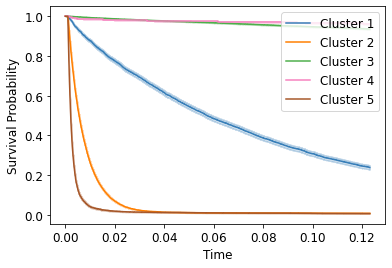

In [15]:
# Plot cluster-specific Kaplan-Meier curves
plot_group_kaplan_meier(t=t_train, d=d_train, c=c_hat)

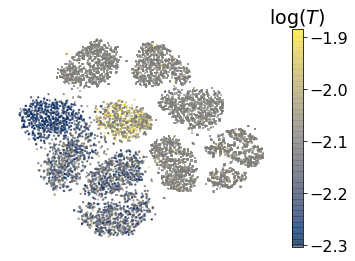

In [16]:
# Visualise learnt representations
plot_tsne_by_survival(X=z_sample[:, 0], t=y_train[:, 0], d=y_train[:, 1], seed=42, plot_censored=True)

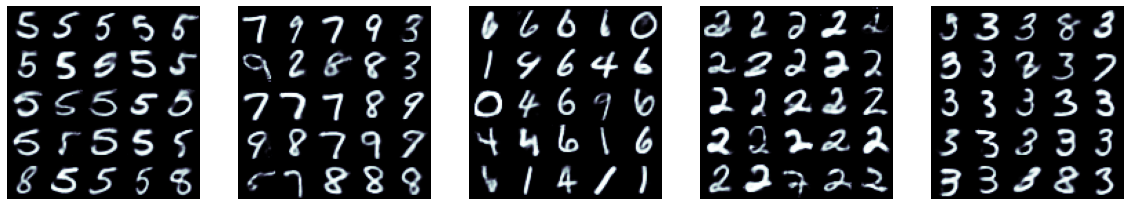

In [17]:
# Visualise generated samples for each cluster
fig, ax = plt.subplots(1, model.num_clusters, figsize=(20,100))

grid_size = 5
inp_size = (28, 28)

for j in range(model.num_clusters):
    samples = model.generate_samples(j=j, n_samples=grid_size**2)
    cnt = 0
    img = None
    for k in range(grid_size):
        row_k = []
        for l in range(grid_size):
            row_k.append(np.reshape(samples[0, cnt, :], (inp_size[0], inp_size[1])))
            cnt = cnt + 1
        if img is None:
            img = np.concatenate(row_k, axis=1)
        else:
            img = np.concatenate([img, np.concatenate(row_k, axis=1)], axis=0)
    ax[j].imshow(img, cmap='bone')
    ax[j].axis('off')

In [18]:
# Evaluate some metrics on the training data
acc = utils.cluster_acc(y_train[:, 2], c_hat)
nmi = normalized_mutual_info_score(y_train[:, 2], c_hat)
ari = adjusted_rand_score(y_train[:, 2], c_hat)
ci = cindex(t=y_train[:, 0], d=y_train[:, 1], scores_pred=risk_scores)
print('ACC: {:.2f}; NMI: {:.2f}; ARI: {:.2f}; CI (tr.): {:.2f}'.format(acc,nmi, ari, ci))

/local/home/anaconda3/envs/Survival_Cluster_Analysis/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


ACC: 0.87; NMI: 0.76; ARI: 0.73; CI (tr.): 0.88


In [19]:
# Now, on the test data
rec, z_sample, p_z_c, p_c_z, risk_scores, lambdas = model.predict((x_test, y_test), batch_size=256)
risk_scores = np.squeeze(risk_scores)
# Hard cluster assignments
c_hat = np.argmax(p_c_z, axis=-1)
acc = utils.cluster_acc(y_test[:, 2], c_hat)
nmi = normalized_mutual_info_score(y_test[:, 2], c_hat)
ari = adjusted_rand_score(y_test[:, 2], c_hat)
ci = cindex(t=y_test[:, 0], d=y_test[:, 1], scores_pred=risk_scores)
print('ACC: {:.2f}; NMI: {:.2f}; ARI: {:.2f}; CI (te.): {:.2f}'.format(acc,nmi, ari, ci))

ACC: 0.86; NMI: 0.74; ARI: 0.72; CI (te.): 0.84


/local/home/anaconda3/envs/Survival_Cluster_Analysis/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
